In [ ]:

# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from matplotlib import rc
import seaborn as sns
%matplotlib inline

# 한글 폰트 설정하기
import matplotlib.font_manager as fm

path = 'C:\\WINDOWS\\Fonts\\나눔고딕Bold.ttf'
fontprop = fm.FontProperties(fname=path)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,494 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [9]:
!unzip -qq '/content/drive/MyDrive/pytorch/test/test.zip' -d '/content/drive/MyDrive/pytorch/test/'
!unzip -qq '/content/drive/MyDrive/pytorch/train/train.zip' -d '/content/drive/MyDrive/pytorch/train/'

In [ ]:
import os
import shutil


directory_list = [
    '/content/drive/MyDrive/pytorch/train/',
    '/content/drive/MyDrive/pytorch/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [ ]:
query = '쌍용 Rexton sports khan'

dataset_split(query, 80)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [10]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/pytorch'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 9240
테스트 데이터셋 크기: 660
클래스: ['AVANTE', 'CASPER', 'EV6', 'G70', 'GRANDEUR', 'GV60', 'IONIQ5', 'IONIQ6', 'K5', 'K8', 'K9', 'KONA', 'Korando', 'Morning', 'NEXO', 'NiroEV', 'PALISADE', 'Ray', 'Rexton', 'SANTAFE', 'SONATA', 'STARIA', 'Seltos', 'Sorento', 'Sportage', 'Stinger', 'TUCSON', 'Tivoli', 'Torres', 'VENUE', 'qm6', 'sm6', 'xm3']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


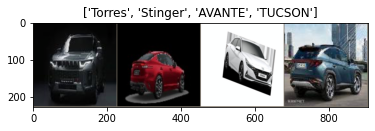

In [11]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [14]:
model = models.resnet34(pretrained=True) #resnet34라는 미리 학습된 모델.
# output layer를 현재 data에 맞게 수정합니다.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 33)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # lr이 학습률, momentum

In [ ]:
num_epochs = 10
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))